<a href="https://colab.research.google.com/github/azizsayadi1155/Customer-Segmentation-Retail-Store/blob/main/Customer_Segmentation_for_a_Retail_Store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation for a Retail Store

**Description:** This project aims to segment customers based on their purchasing behavior to help a retail store understand different customer groups and tailor marketing strategies accordingly. This project will involve clustering techniques.

**Dataset:** https://archive.ics.uci.edu/dataset/352/online+retail

**Objectives:**

1. Apply RFM Analysis and Clustering techniques
2. Achieve at least 90% Silhouette Score on both K-Means and Hierarchical

**Project Author:** Aziz Sayadi

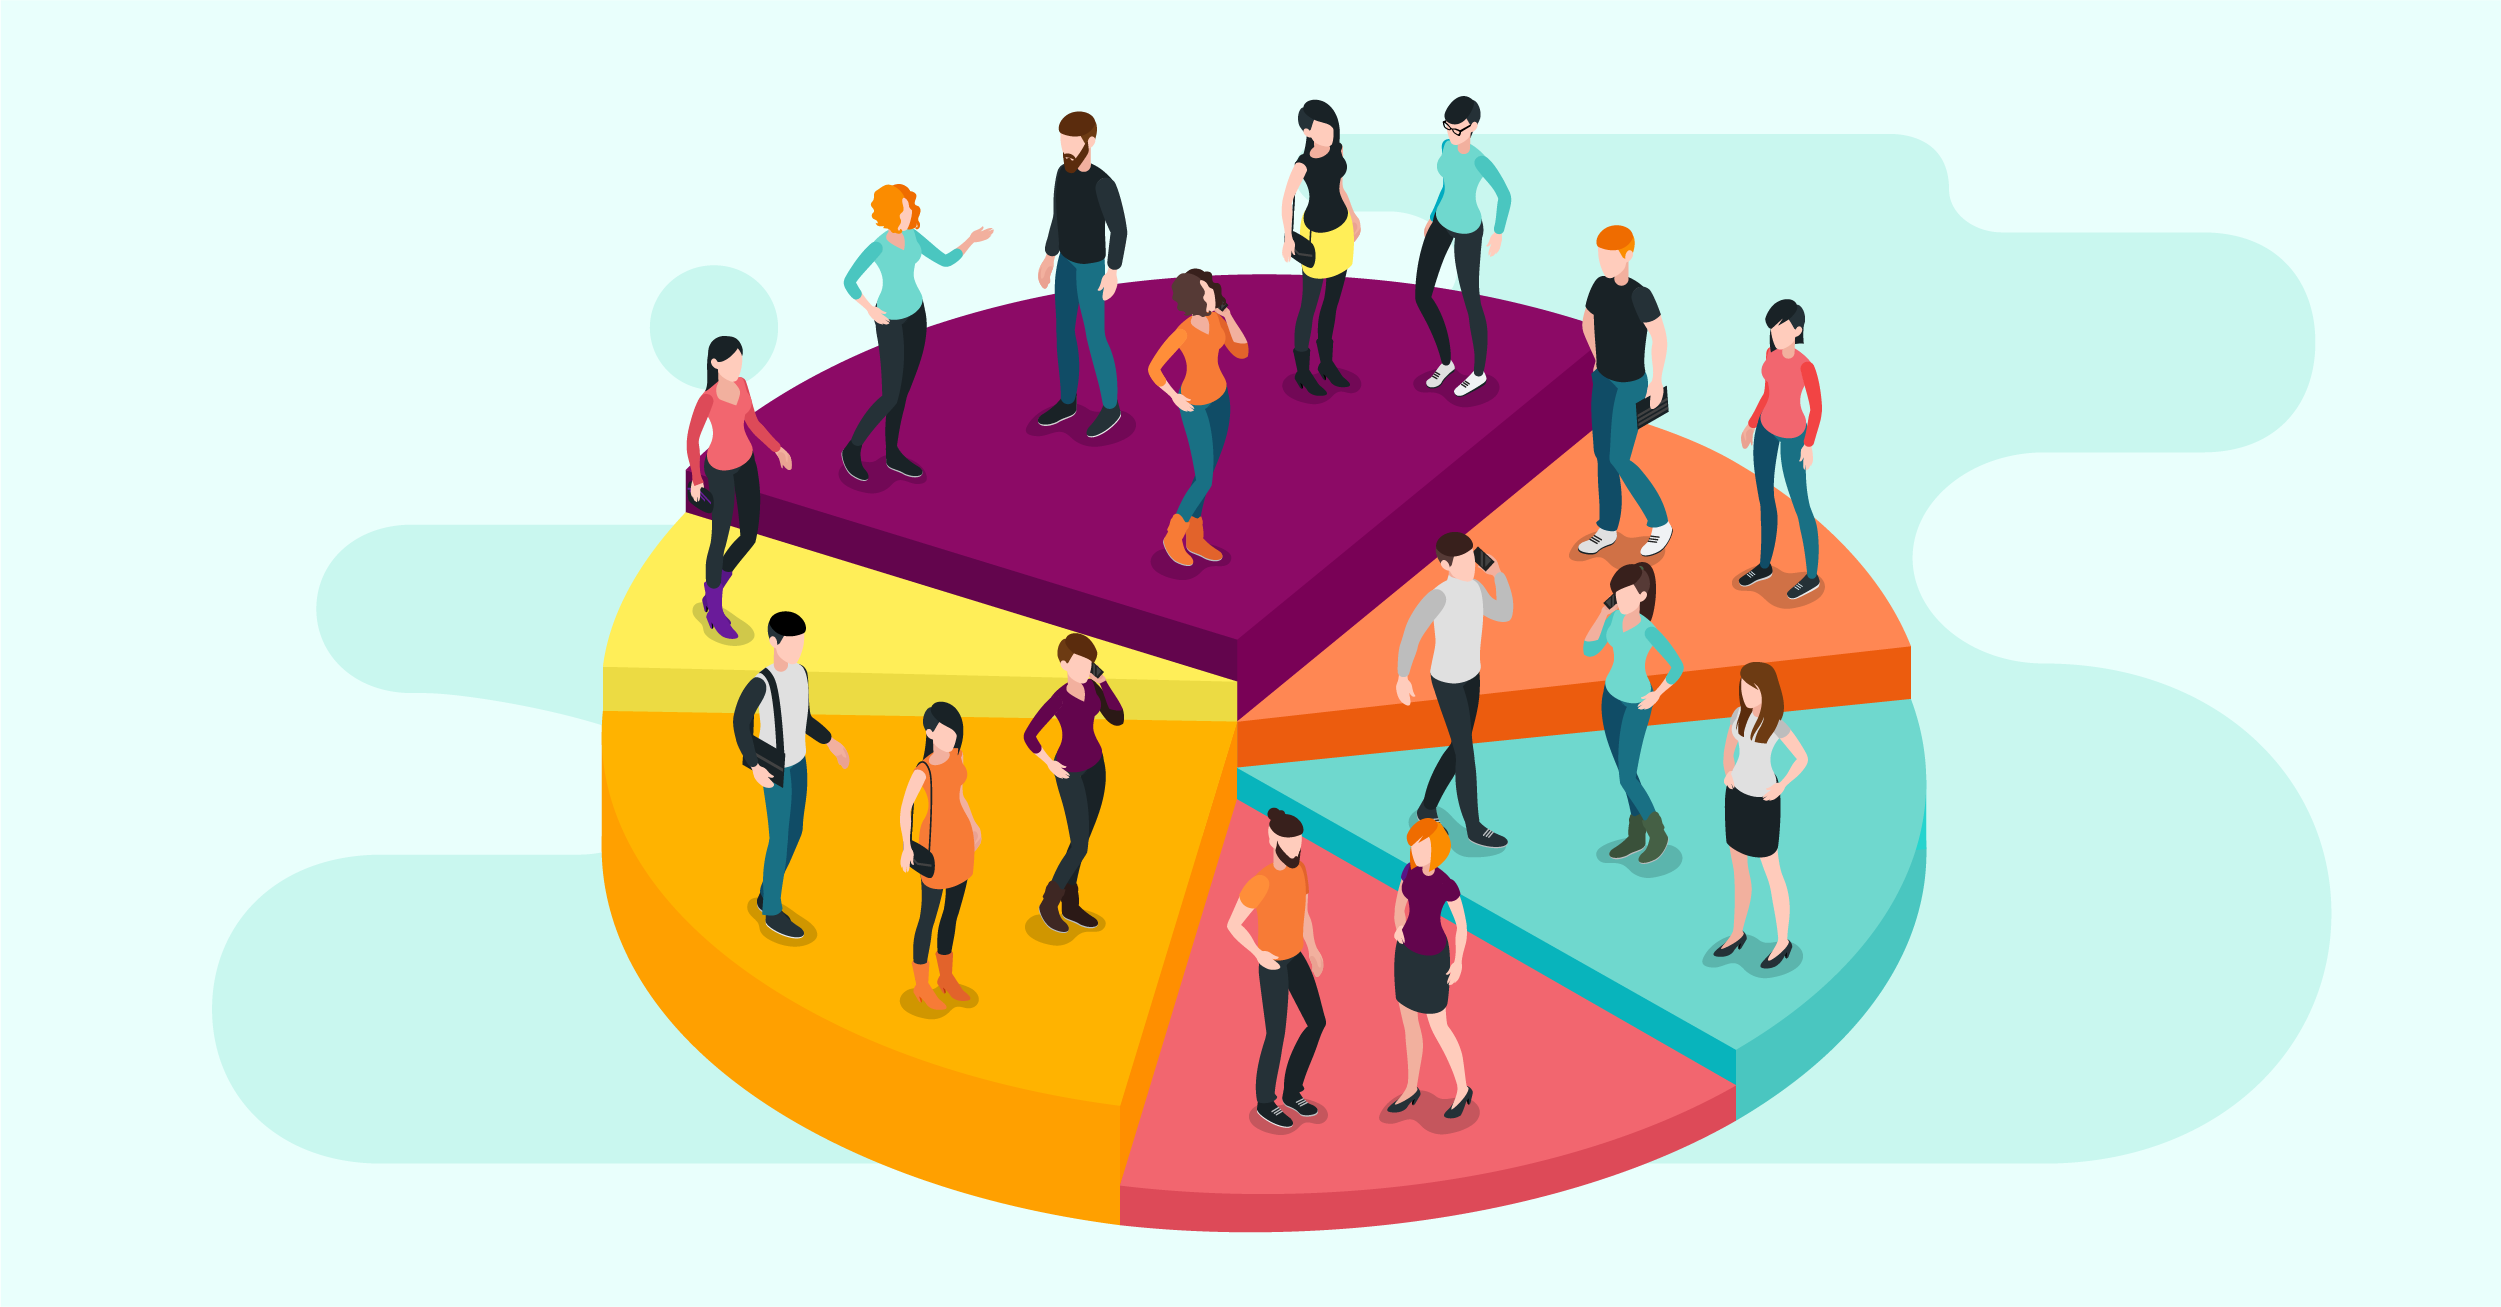

# Importing Libraries

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Data Collection

In [ ]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
df.dropna(subset=['CustomerID','Description'], inplace=True)

In [ ]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [ ]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  float64       
 7   Country      392692 non-null  object        
 8   TotalAmount  392692 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.0+ MB


# Feature Engineering

## Create RFM (Recency, Frequency, Monetary) Features

In [ ]:
# Recency: Days since the last purchase
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
df['Recency'] = (snapshot_date - df['InvoiceDate']).dt.days
recency_df = df.groupby('CustomerID').agg({'Recency': 'min'}).reset_index()

In [ ]:
# Frequency: Number of transactions
frequency_df = df.groupby('CustomerID').agg({'InvoiceNo': 'nunique'}).reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

In [ ]:
# Monetary: Total spent by the customer
monetary_df = df.groupby('CustomerID').agg({'TotalAmount': 'sum'}).reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']

In [ ]:
# Combine RFM Features
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')


In [ ]:
rfm_df.sample(10)

,CustomerID,Recency,Frequency,Monetary
1434,14298.0,8,44,51527.30
351,12785.0,364,1,311.95
2810,16175.0,94,4,1037.59
993,13689.0,63,1,910.00
2778,16134.0,22,2,618.09
2405,15620.0,57,3,1553.18
1935,15002.0,116,4,1641.76
348,12782.0,5,5,2330.92
1146,13894.0,24,3,564.62
680,13247.0,18,4,501.12


# Exploratory Data Analysis (EDA)

## Visualize Customer Purchasing Behavior

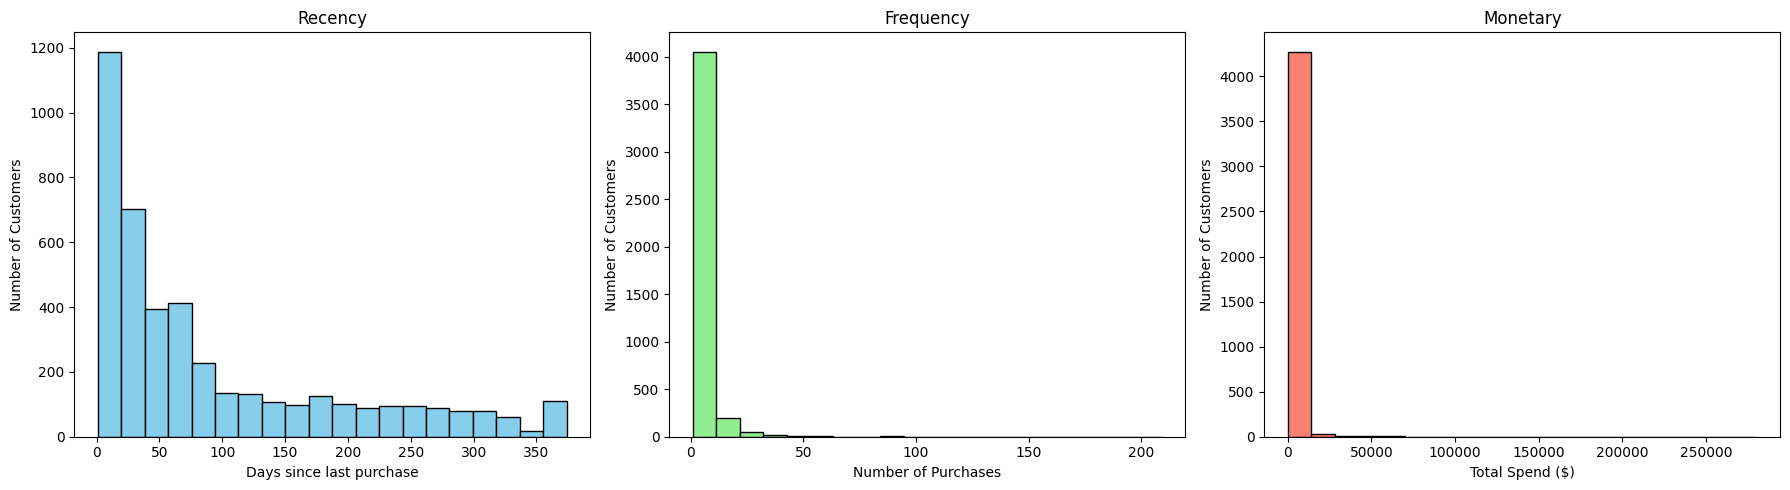

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency Histogram
axes[0].hist(rfm_df['Recency'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Recency')
axes[0].set_xlabel('Days since last purchase')
axes[0].set_ylabel('Number of Customers')

# Frequency Histogram
axes[1].hist(rfm_df['Frequency'], bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title('Frequency')
axes[1].set_xlabel('Number of Purchases')
axes[1].set_ylabel('Number of Customers')

# Monetary Histogram
axes[2].hist(rfm_df['Monetary'], bins=20, color='salmon', edgecolor='black')
axes[2].set_title('Monetary')
axes[2].set_xlabel('Total Spend ($)')
axes[2].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

# Modelling

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Model Evaluation

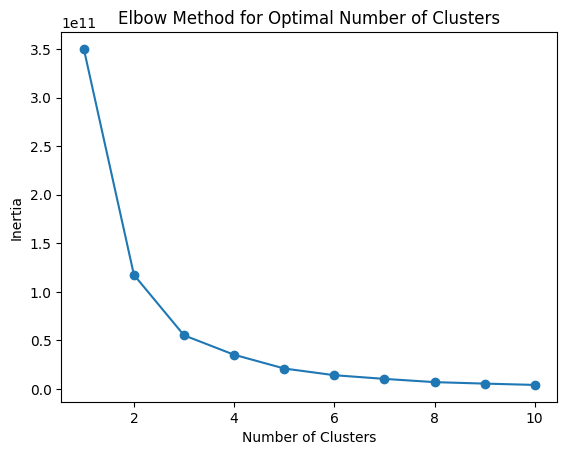

In [ ]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_df[['Recency', 'Frequency', 'Monetary']])
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [ ]:
silhouette_avg = silhouette_score(rfm_df[['Recency', 'Frequency', 'Monetary']], rfm_df['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.9543777173542397


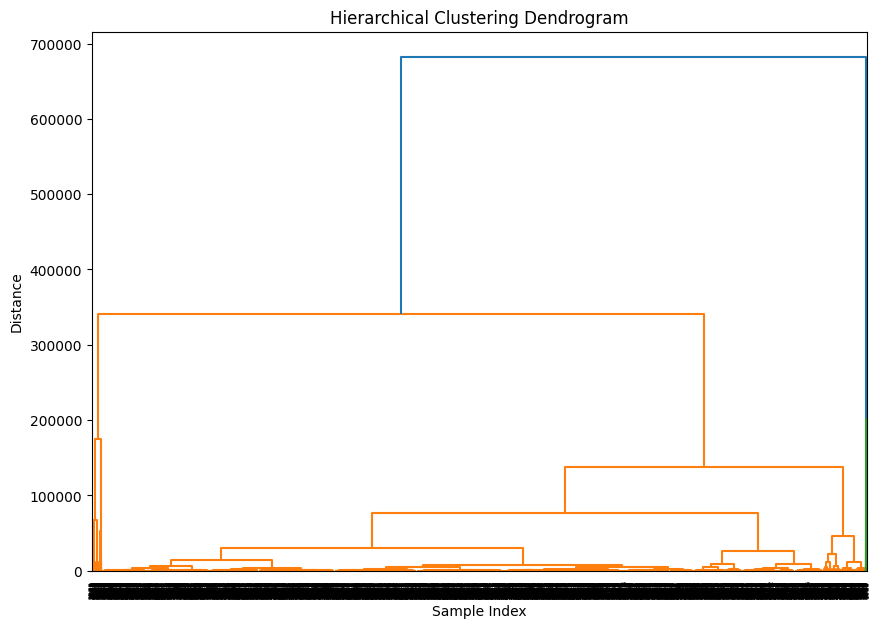

In [ ]:
linked = linkage(rfm_df[['Recency', 'Frequency', 'Monetary']], method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
rfm_df['HCluster'] = fcluster(linked, t=4, criterion='maxclust')
silhouette_avg_hc = silhouette_score(rfm_df[['Recency', 'Frequency', 'Monetary']], rfm_df['HCluster'])
print(f'Silhouette Score (Hierarchical Clustering): {silhouette_avg_hc}')

Silhouette Score (Hierarchical Clustering): 0.9396979943736141


# Interpretation

In [ ]:
cluster_analysis = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).reset_index()
cluster_analysis.columns = ['Cluster', 'Mean Recency', 'Mean Frequency',
                            'Mean Monetary', 'Customer Count']
print(cluster_analysis)

   Cluster  Mean Recency  Mean Frequency  Mean Monetary  Customer Count
0        0     93.123023        3.894884    1433.017266            4300
1        1      8.800000       65.000000  149739.814000               5
2        2     30.548387       42.774194   46344.266452              31
3        3      1.500000       66.500000  269931.660000               2


# Visualization

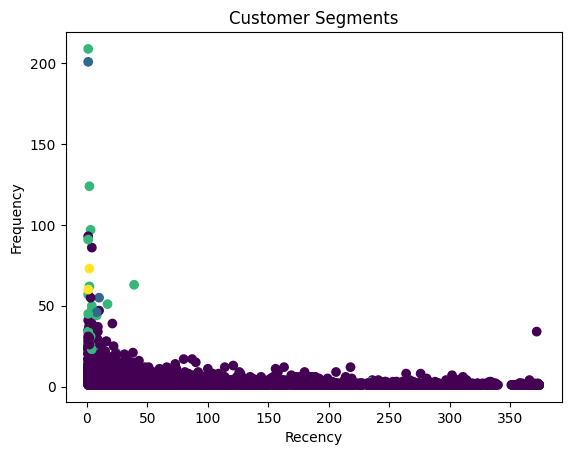

In [ ]:
plt.scatter(rfm_df['Recency'], rfm_df['Frequency'], c=rfm_df['Cluster'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Customer Segments')
plt.show()

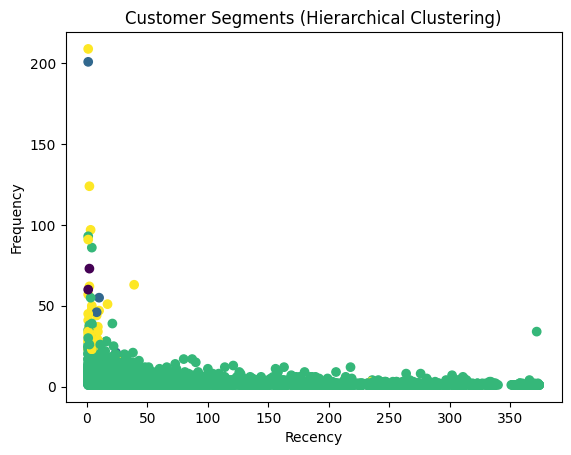

In [ ]:
plt.scatter(rfm_df['Recency'], rfm_df['Frequency'], c=rfm_df['HCluster'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Customer Segments (Hierarchical Clustering)')
plt.show()

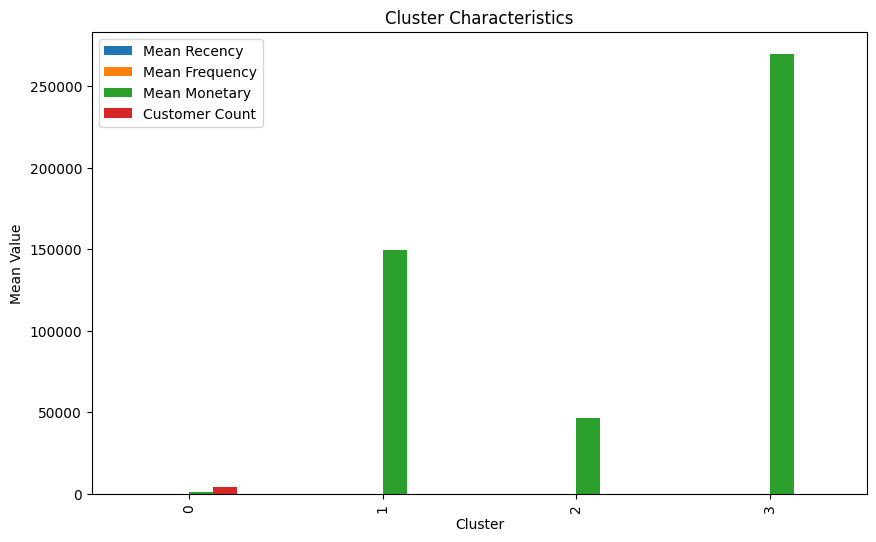

In [ ]:
cluster_analysis.plot(kind='bar', x='Cluster', figsize=(10, 6))
plt.ylabel('Mean Value')
plt.title('Cluster Characteristics')
plt.show()